# IEEE Quantum Week - Tutorial notebook

This notebook contains information and example codes on the content of QuEra's tutorial on neutral-atom quantum computing at IEEE Quantum Week 2023.

To get started let's include some packages that will be useful.

In [9]:
using Graphs
using Bloqade
using Random
Random.seed!(42)
using PythonCall
plt = pyimport("matplotlib.pyplot");

# Single-atom Rabi oscillations

Let's start by looking at the dynamics of a single qubit in the presence of a Rabi drive.

We start by creating a register of a single atom,

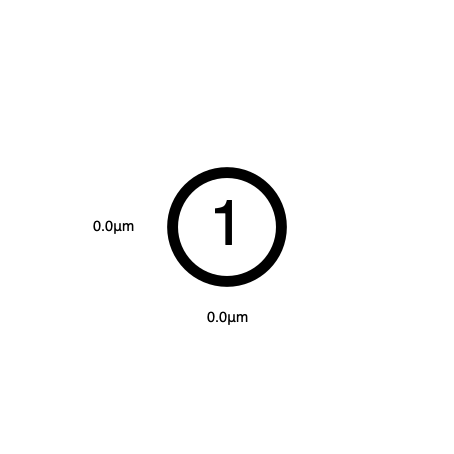

In [2]:
atom1 = AtomList([(0.0, 0.0)])

applying constant waveforms with a Rabi drive $\Omega=2$ MHz

In [4]:
Ω = 2π * 2;
Δ = 0;

and now we feed the info to corresponding Hamiltonian 

In [5]:
h1 = rydberg_h(atom1; Δ = Δ, Ω = Ω)

nqubits: 1
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|r_i-r_j|^6 n_i n_j
├─ [+] 2π ⋅ ∑ σ^x_i
└─ [-] 2π ⋅ 0.0 ⋅ ∑ n_i


Now let's finish the steps to run a quantum job. We start by initializing our register; here we pick the $|\psi(0)\rangle=|0\rangle$ state to set boundary conditions

In [6]:
reg1 = zero_state(1)

ArrayReg{2, ComplexF64, Array...}
    active qubits: 1/1
    nlevel: 2

Now let's consider the actual time evolution. Since we are interested in dynamics here, we have to work a little. We pick a total time of $1.5 \mu s$, discretize time in tiny pieces $\delta t=10^{-2}$ for numerical evolution, and pick a method to solve the time evolution (here we are using `KrylovEvolution`, which deploys an explicit exponentition of the time-evolution operator. It is very efficient but will only work for constant Hamiltonians; otherwise full solution of the Schroedinger's differential equation via `SchroedingerProblem` is needed)

In [7]:
total_time = 1.5
clocks = 0.0:1e-2:total_time
prob1 = KrylovEvolution(reg1, clocks, h1)
density1 = zeros(1, length(clocks));

for info in prob1
    density1[1, info.step] = rydberg_density(info.reg, 1)
end

Finally, let's measure something! Here, we plot the evolution of the mean value of the Rydberg number. We see, as expected $n(t)=\sin^2 (\Omega t)$

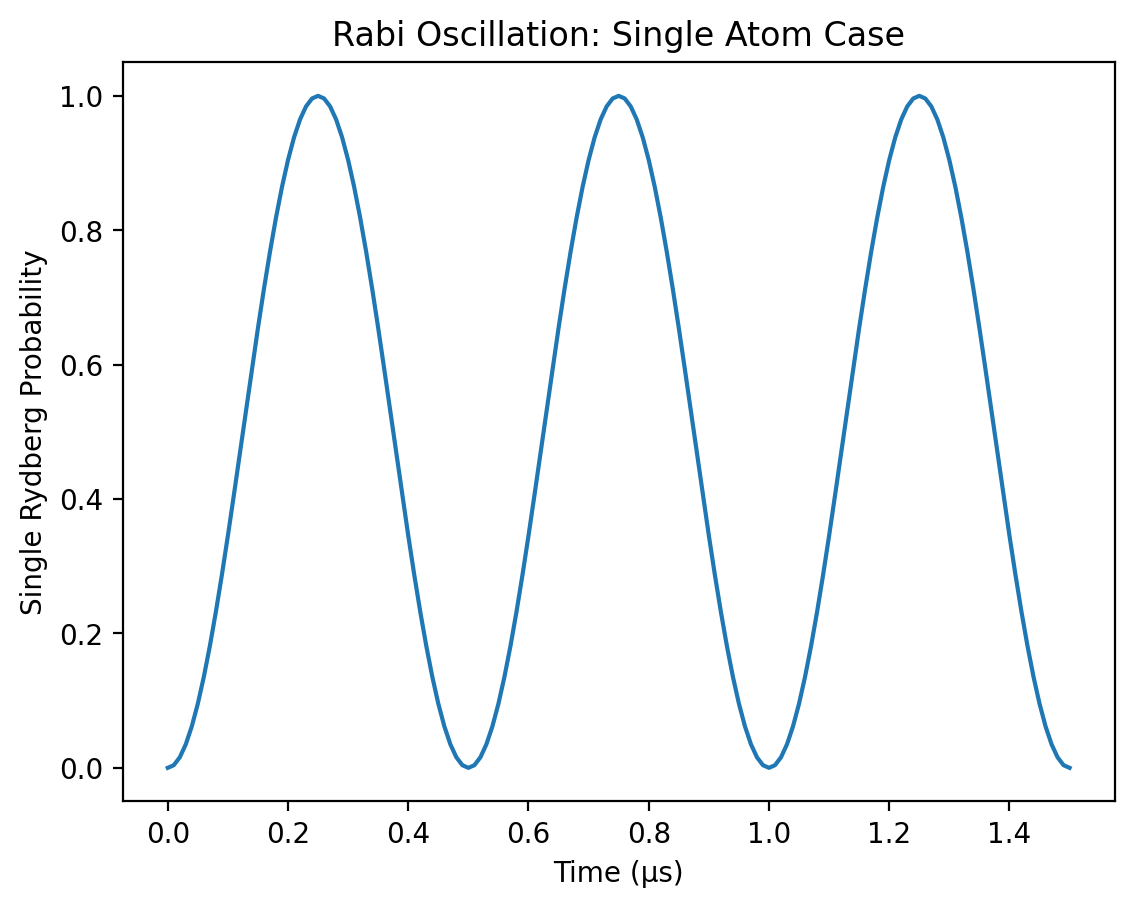

In [8]:
fig, ax = plt.subplots()
ax.plot(clocks, density1[1, :])
ax.set_xlabel("Time (μs)")
ax.set_ylabel("Single Rydberg Probability")
ax.set_title("Rabi Oscillation: Single Atom Case")
fig

## 2 atoms

Let's do this again for 2 atoms. Below we have a simple approach to it.

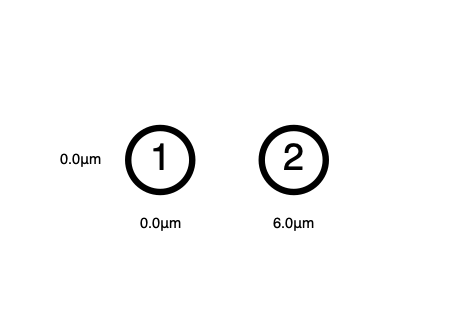

In [32]:
separation=6.0
atom2 = generate_sites(ChainLattice(), 2, scale = separation)

In [33]:
h2 = rydberg_h(atom2; Δ = 0, Ω = 2π * 2)

reg2 = zero_state(2)

total_time = 1.5
clocks = 0.0:1e-2:total_time
prob2 = KrylovEvolution(reg2, clocks, h2)
density2 = zeros(2, length(clocks));

for info in prob2
    for i in 1:2
        density2[i, info.step] = rydberg_density(info.reg, i)
    end
end
density2 = sum(density2, dims = 1);


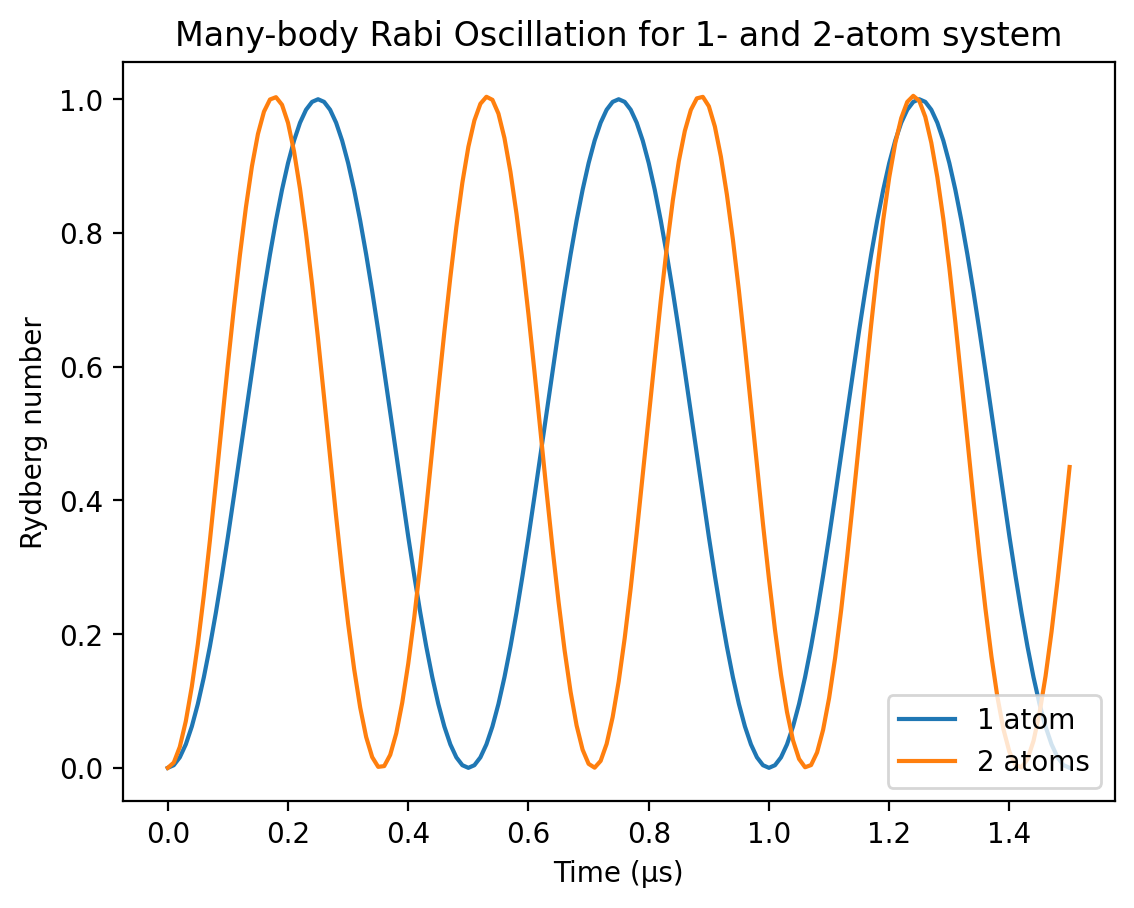

In [34]:
fig, ax = plt.subplots()
ax.plot(clocks, density1[1, :])
ax.plot(clocks, density2[1, :])
ax.set_xlabel("Time (μs)")
ax.set_ylabel("Rydberg number")
ax.set_title("Many-body Rabi Oscillation for 1- and 2-atom system")
ax.legend(["1 atom", "2 atoms"], loc = "lower right")
fig

# Many atoms

## Checkerboards!

Following the lecture discussion, let's try to prepare a checkerboard state

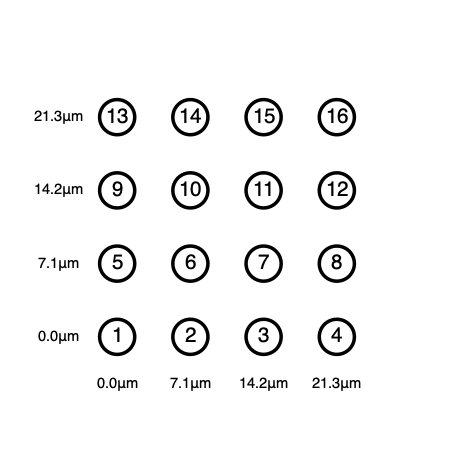

In [10]:
Random.seed!(2)
a=7.1

atoms = generate_sites(SquareLattice(), 4,4; scale = a)

pick a blockade radius according to first-neighbor 

In [11]:
Rb=sqrt(sqrt(2))*a

8.44337051651932

which means

In [12]:
Rb/a

1.189207115002721

Well into the good height in the y-axis of the phase diagram on slide 11 of Session II's slides.

Let's check if we are defining things properly looking at the lattice:

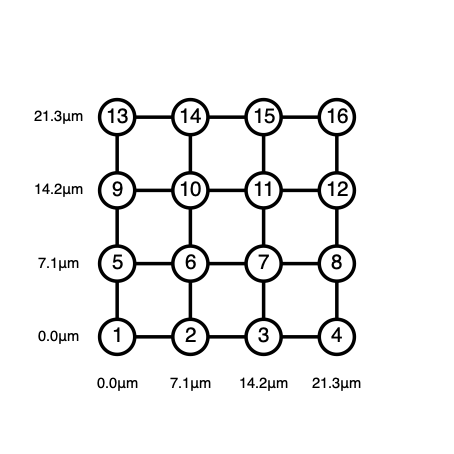

In [13]:
Bloqade.plot(atoms, blockade_radius = Rb)

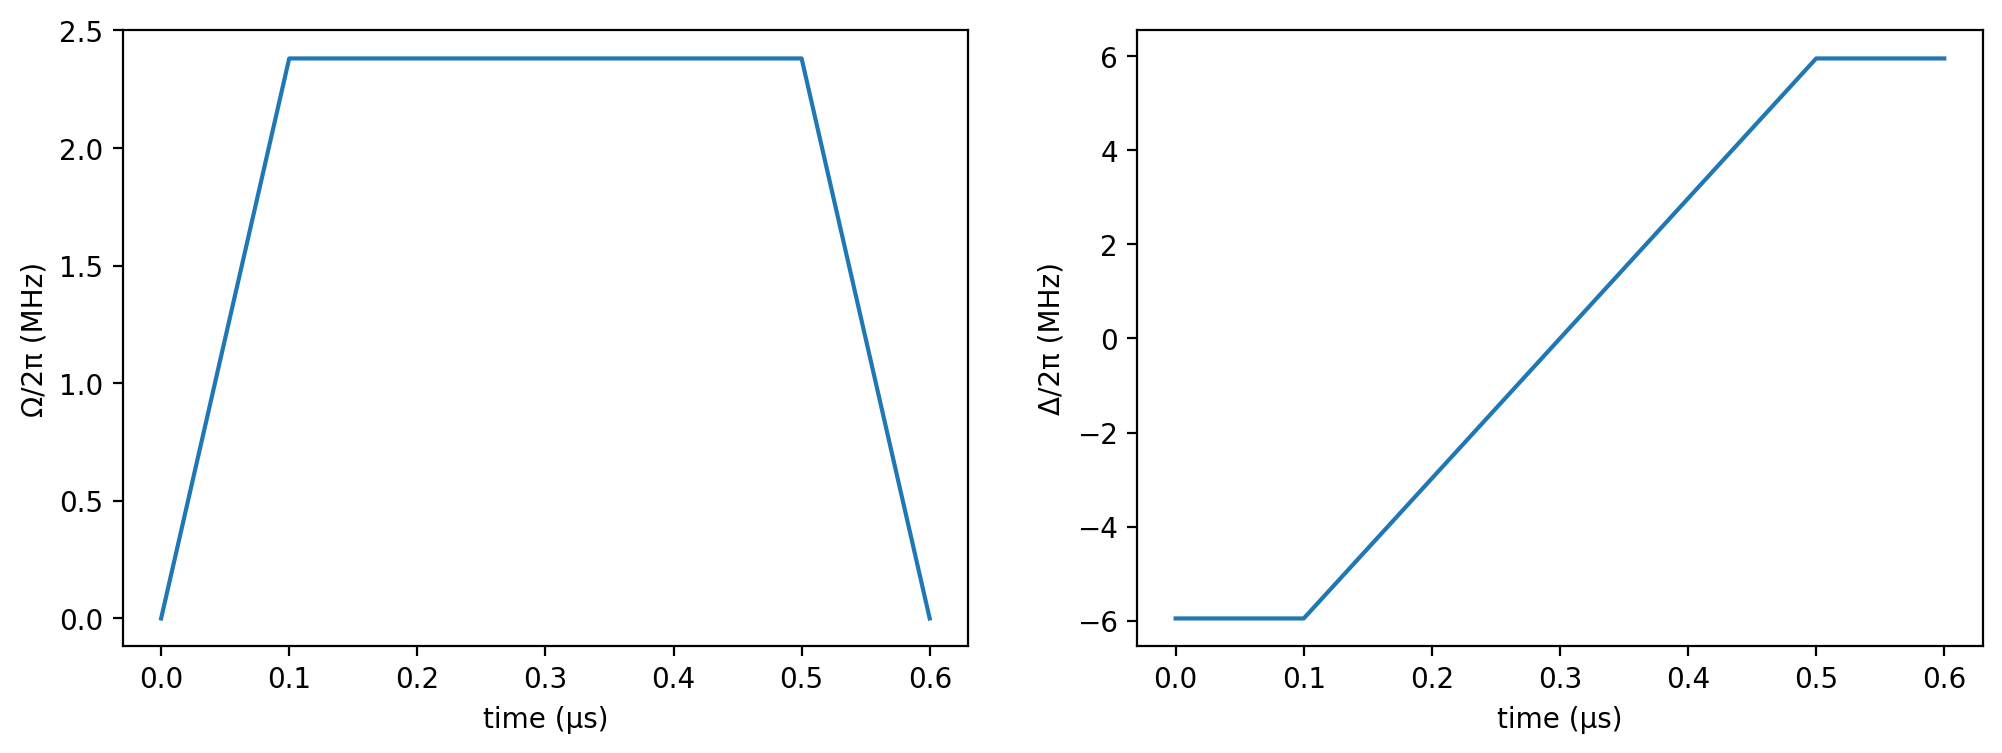

In [14]:
#Fix energetics from blockade radius
C6 = 2π * 862690
Ω_max= C6 / Rb^6

#Total evolution time
T_max = 0.6

Δ_max = 2.5*Ω_max

#Build time traces for adiabatic algorithm
Ω = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [0.0, Ω_max, Ω_max, 0])
Δ_start = -Δ_max
Δ_end = Δ_max
Δ = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])
ϕ = piecewise_constant(clocks=[0.0,T_max], values= [0.0]); #this is not necessary. Here for later use

#Quick plot to check
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

Now run!

In [15]:
h_square = rydberg_h(atoms; Ω = Ω, Δ = Δ, ϕ = ϕ)
prob = SchrodingerProblem(zero_state(nqubits(h_square)), T_max, h_square);

emulate!(prob)

SchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 0.6)

  equation: 
    storage size: 25.000 MiB
    expression:
nqubits: 16
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|r_i-r_j|^6 n_i n_j
├─ [+] Ω(t) ⋅∑ e^{ϕ(t) ⋅ im} |0⟩⟨1| + e^{-ϕ(t) ⋅ im} |1⟩⟨0|
└─ [-] Δ(t) ⋅ ∑ n_i


    algorithm: DP8(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))
  options:
    save_everystep: false
    save_start: false
    save_on: false
    dense: false
    reltol: 1.0e-10
    abstol: 1.0e-10


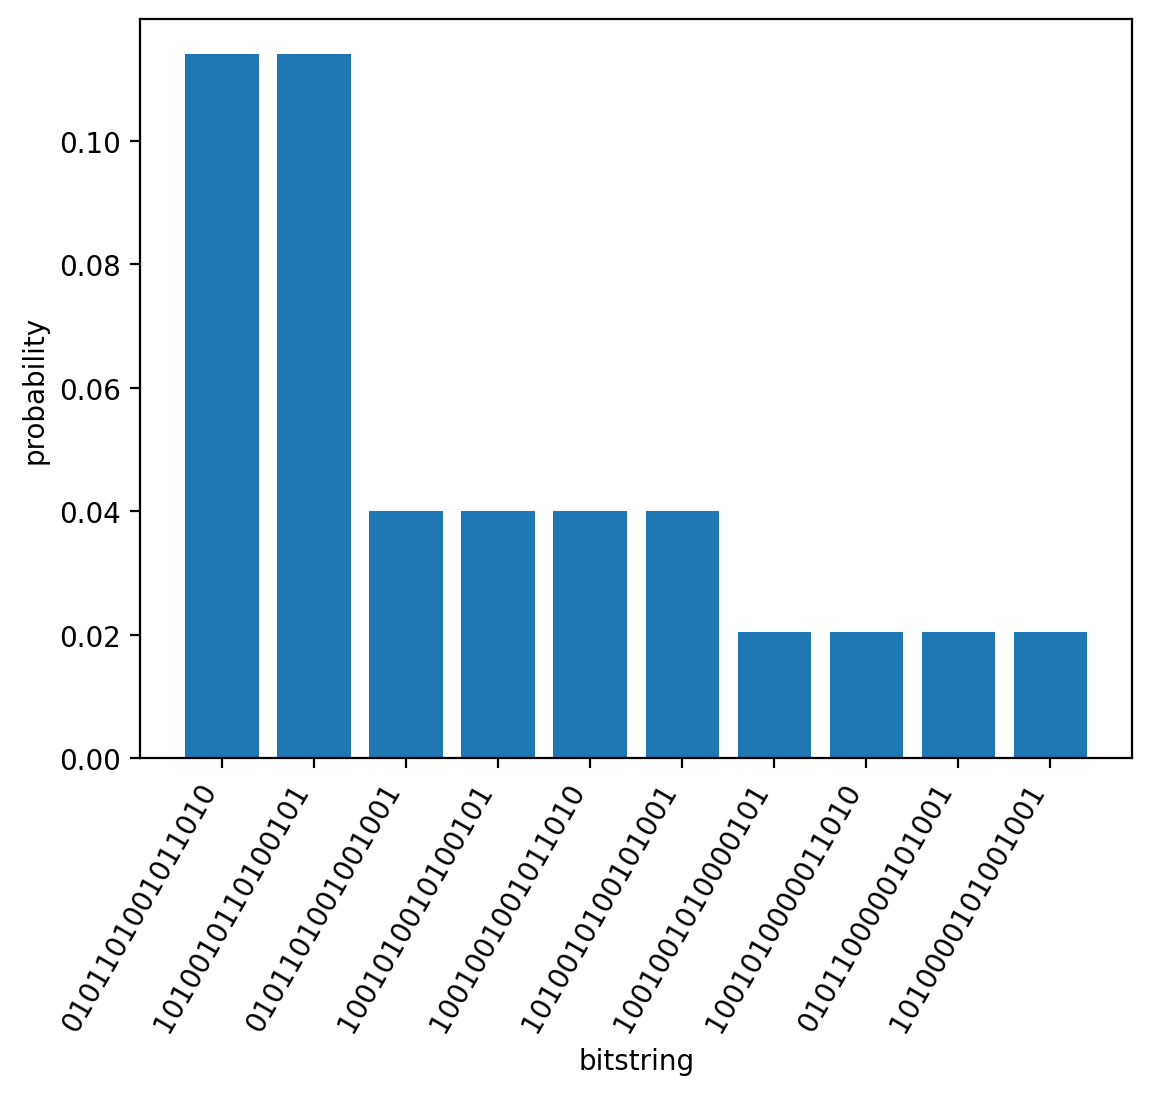

In [16]:
bitstring_hist(prob.reg; nlargest = 10)

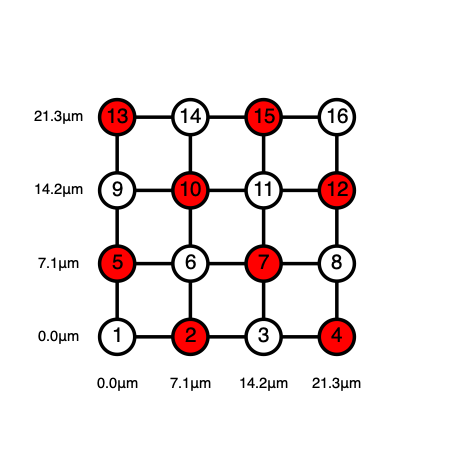

In [17]:
best_bit_strings = most_probable(prob.reg, 4)

Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[1]])


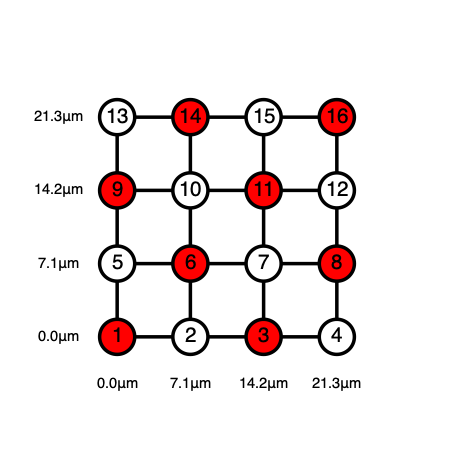

In [18]:
Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[2]])

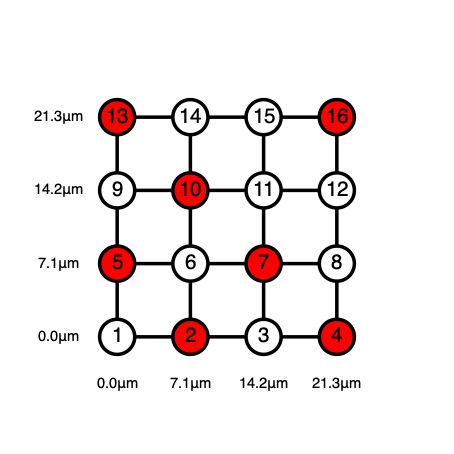

In [60]:
Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[3]])


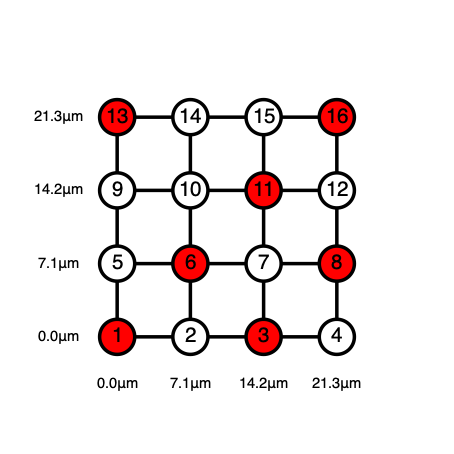

In [61]:
Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[4]])

# Hardware interaction

In [19]:
using BloqadeSchema

### Transformation example: atom positions

In [21]:
atom_positions = ((1.12,), (2.01,), (3.01,));
hardware_transform_atoms(atom_positions)

([(1.1,), (2.0,), (3.0,)], 0.013333333333333197)

### Transformation example: waveforms

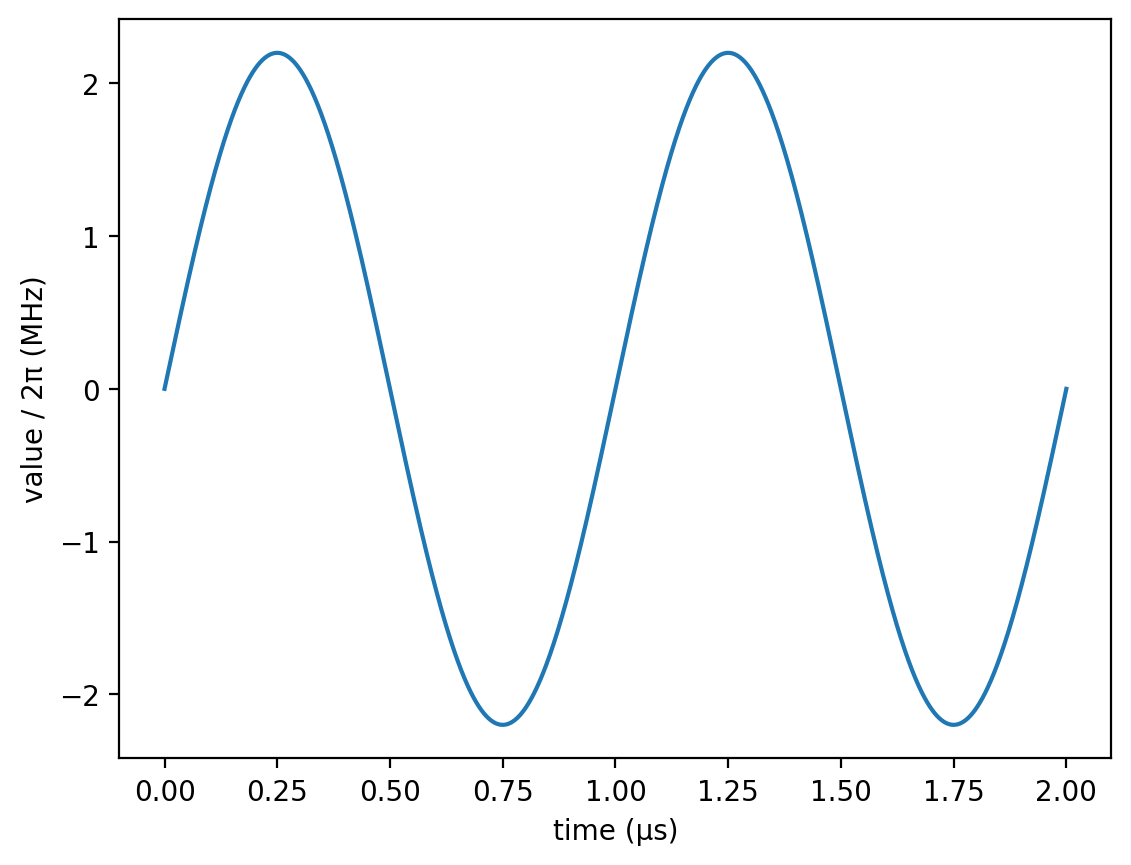

In [22]:
smooth_ϕ = Waveform(t->2.2*2π*sin(2π*t), duration = 2);
Bloqade.plot(smooth_ϕ)

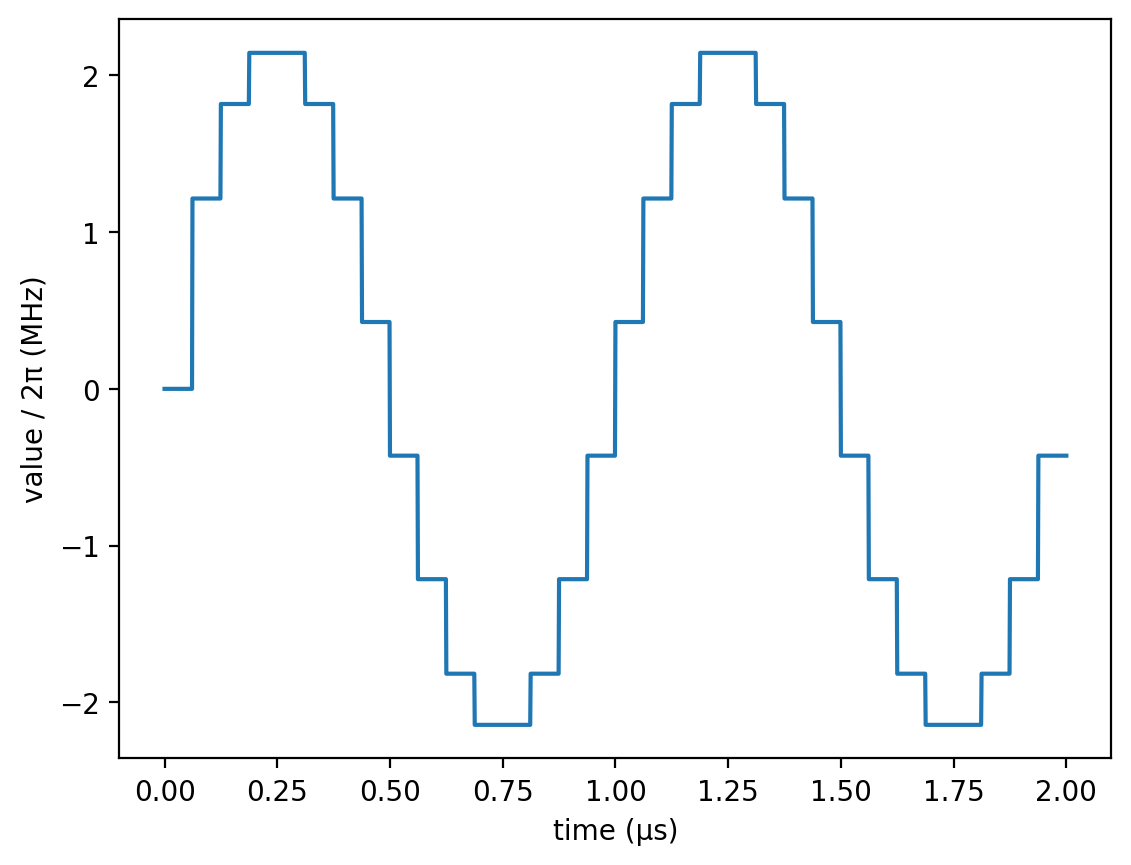

In [23]:
discretized_ϕ, _ =   hardware_transform_ϕ(smooth_ϕ)
Bloqade.plot(discretized_ϕ)

### General Hamiltonian transformation

In [25]:
transformed_h, transform_info = hardware_transform(h_square)
dump(transform_info)

HardwareTransformInfo
  ϕ_error: Float64 0.0
  Ω_error: Float64 6.302332531475362e-5
  Δ_error: Float64 3.334878335985534e-8
  Δ_mask: NamedTuple{(:Δ, :δ, :Δi), Tuple{Waveform{BloqadeWaveforms.PiecewiseLinear{Float64, Interpolations.Extrapolation{Float64, 1, Interpolations.GriddedInterpolation{Float64, 1, Float64, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{Vector{Float64}}}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Interpolations.Throw{Nothing}}}, Float64}, Nothing, Float64}}
    Δ: Waveform{BloqadeWaveforms.PiecewiseLinear{Float64, Interpolations.Extrapolation{Float64, 1, Interpolations.GriddedInterpolation{Float64, 1, Float64, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{Vector{Float64}}}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Interpolations.Throw{Nothing}}}, Float64}
      

## Validation

In [24]:
validate(transformed_h)

The following validation violations occured:



## Braket submission pipeline

In [ ]:
using AWS
access_key_id = "your_access_key_id"
secret_key = "your_secret_key"
token = "your_token"
credentials = AWS.AWSCredentials(access_key_id, secret_key, token)

### Submission

In [ ]:
task = submit_to_braket(transformed_h, 10; credentials=credentials)

### Retrieval

In [ ]:
using Braket
Braket.state(task) #checks if task is queued, etc - general status

In [ ]:
res = Braket.result(task) # pulls the result

We can perform some analysis directly on the `AnalogHamiltonianSimulationQuantumTaskResult` with the same density plotting function but a different function for calculationg the rydberg_density that works directly on such objects.

In [ ]:
plot_densities(atoms, BloqadeSchema.rydberg_density(res))